## 1. Import Libraries and Load Data

In [70]:
# Libraries
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_5')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_5


In [32]:
# Load the data
df = pd.read_csv("./data/processed/processed_database.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72612 entries, 0 to 72611
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          72612 non-null  int64  
 1   f_orders         72612 non-null  int64  
 2   f_products       72612 non-null  int64  
 3   f_returning      72612 non-null  int64  
 4   m_price_log      72612 non-null  float64
 5   m_freight_log    72612 non-null  float64
 6   m_pct_freight    72612 non-null  float64
 7   m_credit         72612 non-null  float64
 8   s_review_score   72612 non-null  float64
 9   s_delivery_diff  72612 non-null  float64
 10  product_score    72612 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 6.1 MB


## 2. Functions

In [83]:
def evaluate_clusters(
    data,
    feature_cols,
    metric="distortion",
    k_min=2,
    k_max=10,
    random_state=42
):
    """
    Evaluate clustering (elbow, silhouette, intercluster distance) for a set of features.
    """
    # Subset and scale
    X = data[feature_cols]
    
    fig, axes = plt.subplots(3, 1, figsize=(6, 10))
    
    # Elbow plot
    elbow_pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('kelbow', KElbowVisualizer(
            KMeans(random_state=random_state),
            k=(k_min, k_max),
            metric=metric,
            ax=axes[0]
        ))
    ])
    elbow_pipe.fit(X)
    best_k = elbow_pipe.named_steps['kelbow'].elbow_value_
    elbow_pipe.named_steps['kelbow'].finalize()
    
    # Silhouette plot at best_k
    silhouette_pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('sil', SilhouetteVisualizer(
            KMeans(n_clusters=best_k, random_state=random_state),
            ax=axes[1]
        ))
    ])
    silhouette_pipe.fit(X)
    silhouette_pipe.named_steps['sil'].finalize()
    
    # Intercluster distance plot at best_k
    interdist_pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('icd', InterclusterDistance(
            KMeans(n_clusters=best_k, random_state=random_state),
            ax=axes[2]
        ))
    ])
    interdist_pipe.fit(X)
    interdist_pipe.named_steps['icd'].finalize()
    
    # Show everything
    plt.tight_layout()
    plt.show()
    
    return best_k, fig

In [53]:
def best_k_by_calinski(X, k_list, scale=True):
    """
    Returns the K in k_list with the highest Calinski–Harabasz score.
    """
    if scale:
        X_proc = RobustScaler().fit_transform(X)
    else:
        X_proc = X

    scores = {}
    for k in k_list:
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_proc)
        scores[k] = calinski_harabasz_score(X_proc, labels)

    best_k = max(scores, key=scores.get)
    return best_k, scores

In [74]:
def best_k_by_davies(
    X,
    k_list,
    scale: bool = True,
    scaler: object = RobustScaler(),
    random_state: int = 42
):
    """
    Returns the K in k_list with the lowest Davies–Bouldin score.
    """
    if scale:
        X_proc = scaler.fit_transform(X)
    else:
        X_proc = X


    scores = {}
    for k in k_list:
        labels = KMeans(n_clusters=k, random_state=random_state).fit_predict(X_proc)
        scores[k] = davies_bouldin_score(X_proc, labels)

    best_k = min(scores, key=scores.get)
    return best_k, scores

## 3. Comparing Models

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72612 entries, 0 to 72611
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          72612 non-null  int64  
 1   f_orders         72612 non-null  int64  
 2   f_products       72612 non-null  int64  
 3   f_returning      72612 non-null  int64  
 4   m_price_log      72612 non-null  float64
 5   m_freight_log    72612 non-null  float64
 6   m_pct_freight    72612 non-null  float64
 7   m_credit         72612 non-null  float64
 8   s_review_score   72612 non-null  float64
 9   s_delivery_diff  72612 non-null  float64
 10  product_score    72612 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 6.1 MB


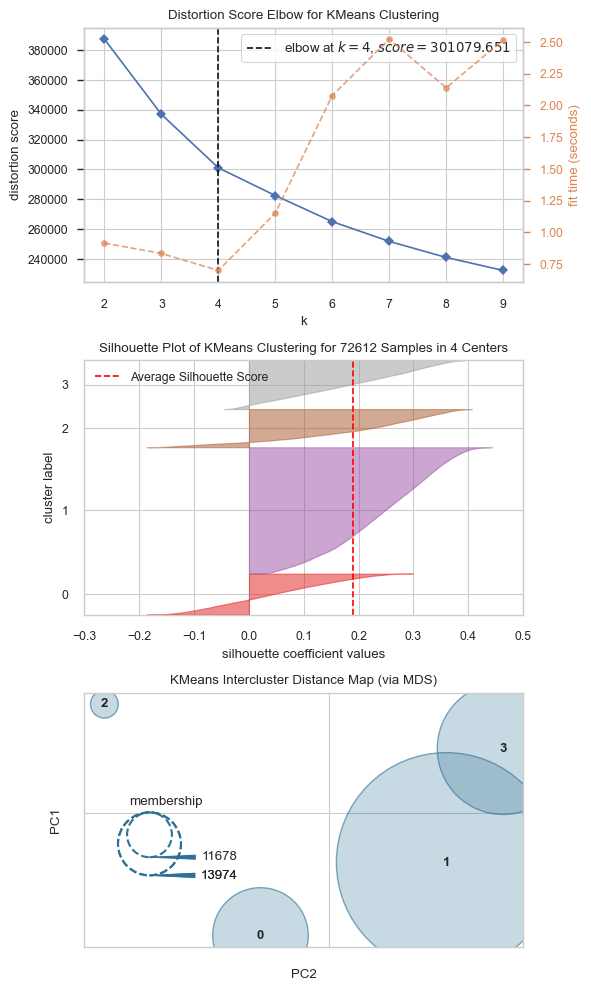

Optimal number of clusters according to the elbow: 4


In [82]:
# Evaluate clusters: All features
feature_cols = [
    col for col in df.columns
    if col != 'customer_unique_id'
] # can drop this

best_k, fig = evaluate_clusters(
    data=df,
    feature_cols=feature_cols,
    metric="distortion",
    k_min=2,
    k_max=10
)

print("Optimal number of clusters according to the elbow:", best_k)

In [66]:
# Calinski-Harabasz (CH) index
feature_cols = [c for c in df.columns if c!='customer_unique_id']
X = df[feature_cols].values

k_list = range(2, 7)
best_k, all_scores = best_k_by_calinski(X, k_list, scale=True)

print("CH scores by K:", all_scores)
print("Best K according to CH:", best_k)

CH scores by K: {2: 17284.87096131886, 3: 14439.701202233642, 4: 12723.201322122377, 5: 11925.56372793875, 6: 11266.08220183833}
Best K according to CH: 2


In [68]:
# Davies–Bouldin scores
feature_cols = [c for c in df.columns if c != 'customer_unique_id']
X = df[feature_cols].values

k_list = range(2, 7)

best_k_db, db_scores = best_k_by_davies(X, k_list, scale=True)

print("Davies–Bouldin scores by K:", db_scores)
print("Best K (lowest DB):", best_k_db)

Davies–Bouldin scores by K: {2: 1.4269978987899496, 3: 1.898639388913815, 4: 1.703805454952538, 5: 1.582295935532089, 6: 1.6666353419045095}
Best K (lowest DB): 2


## Comapring models with dictionary

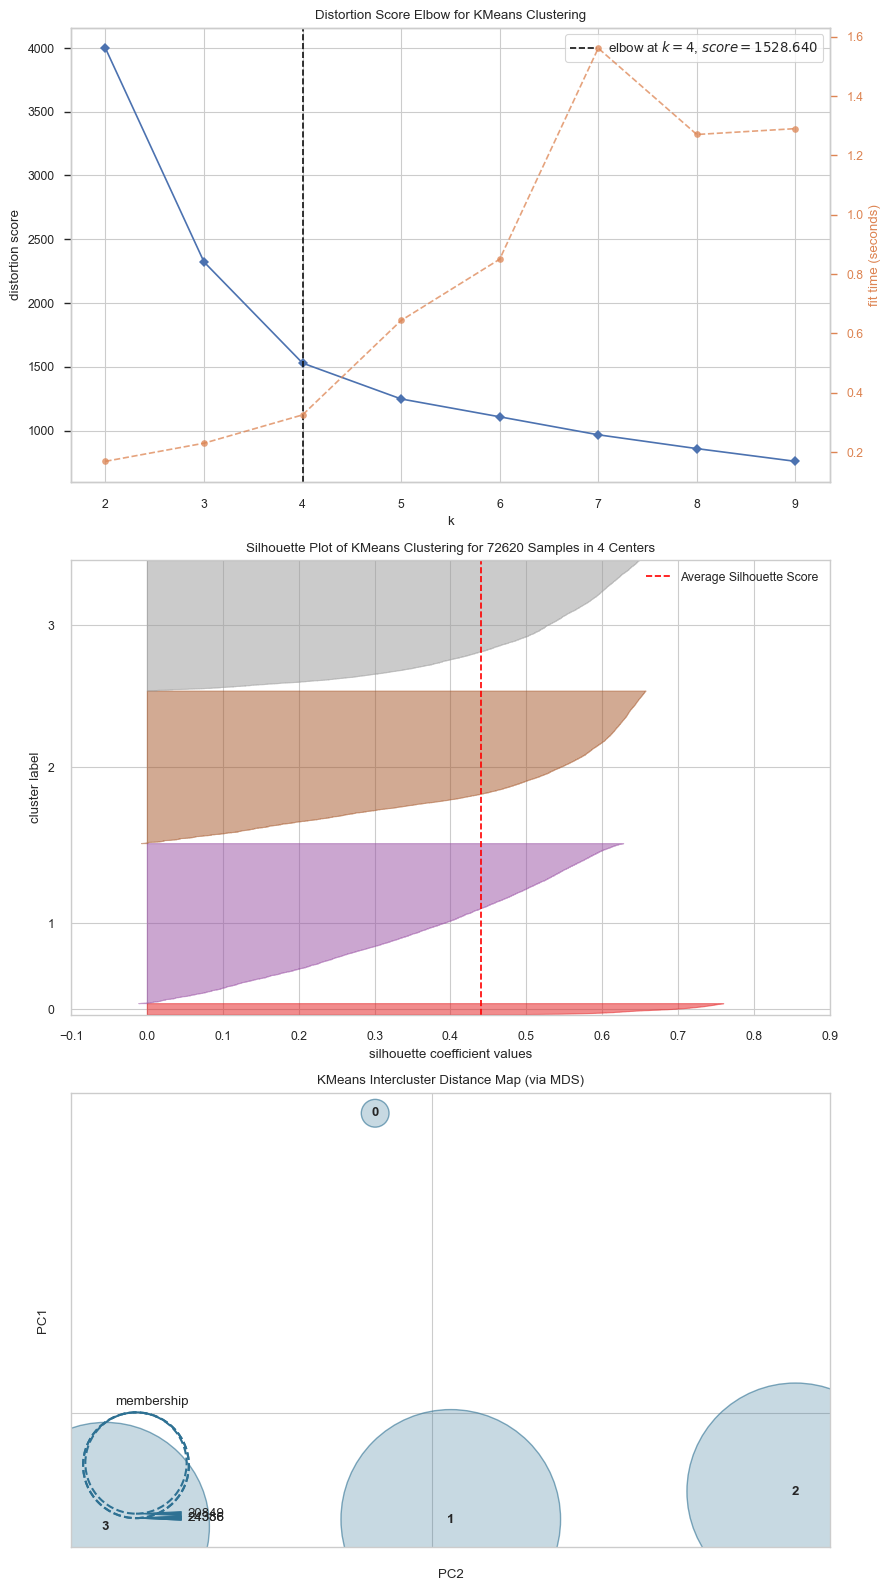

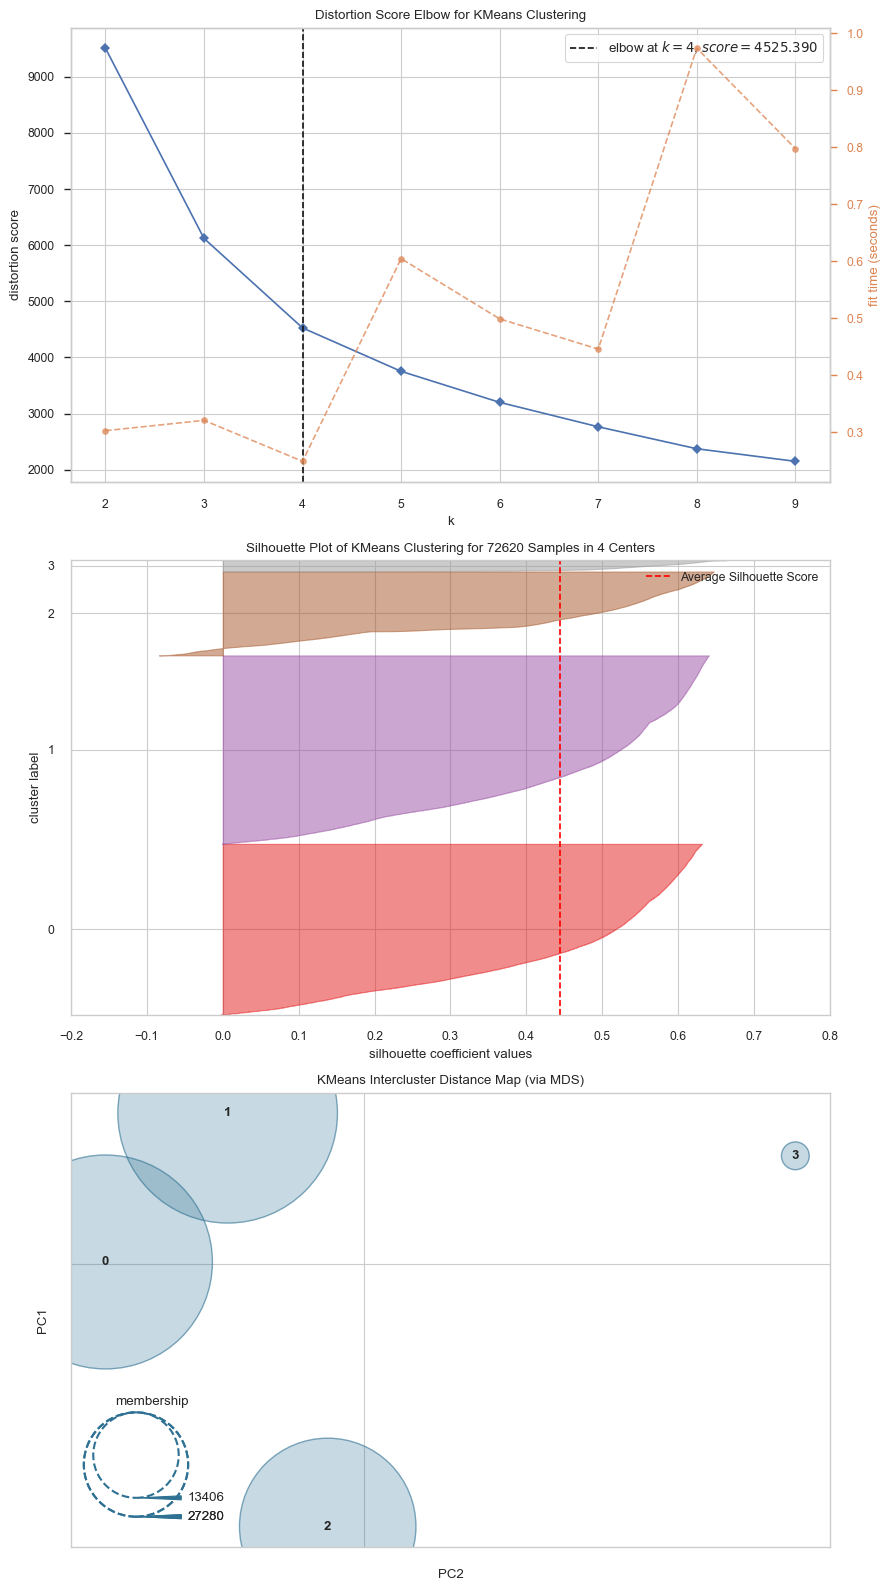

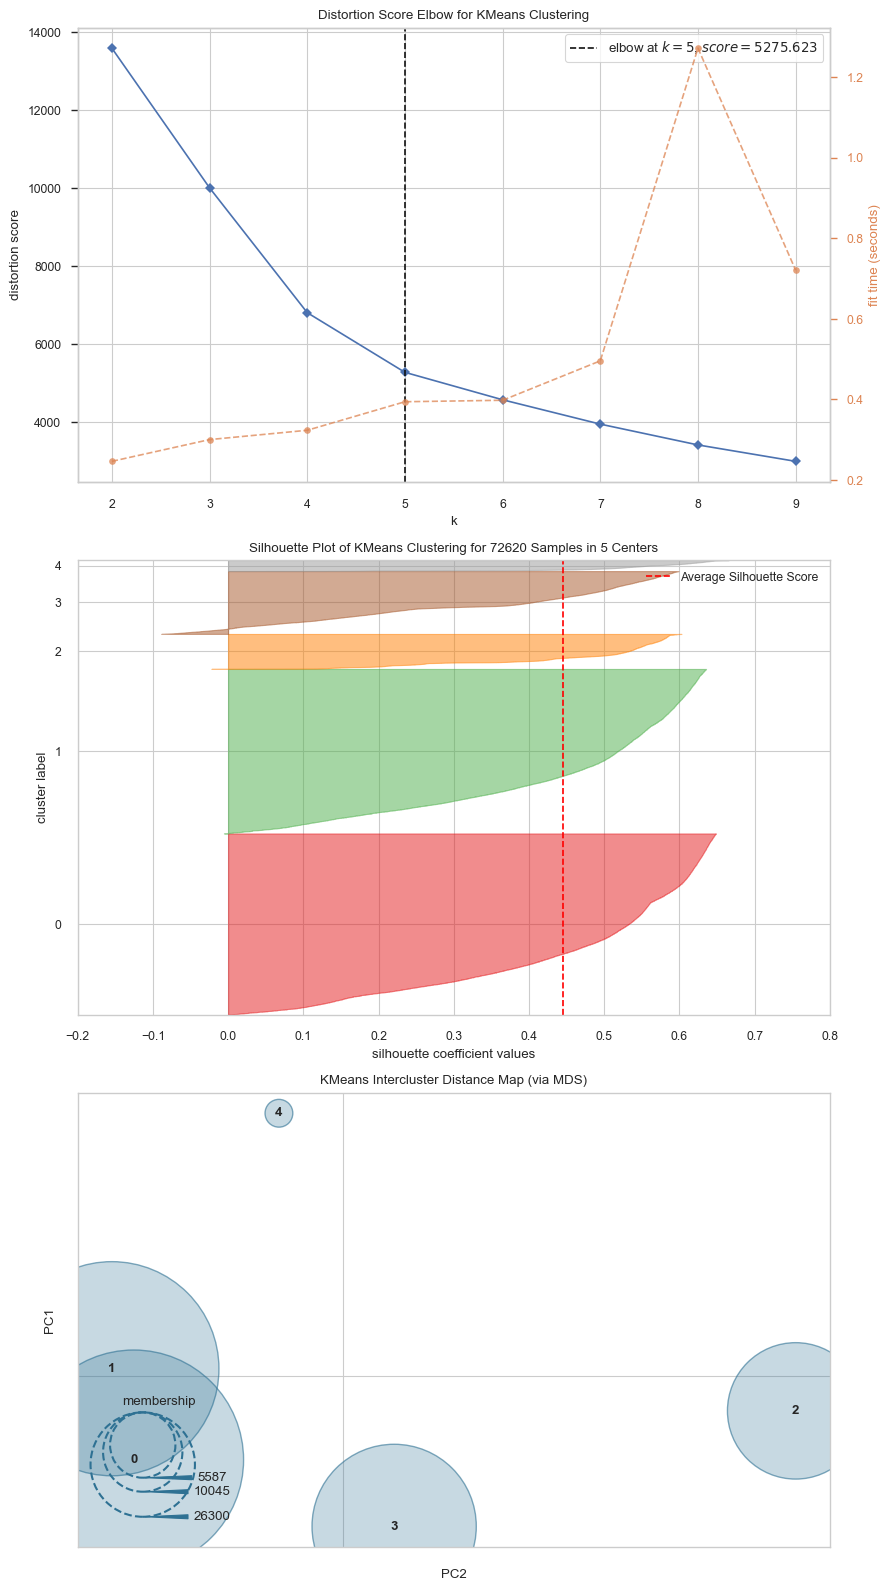

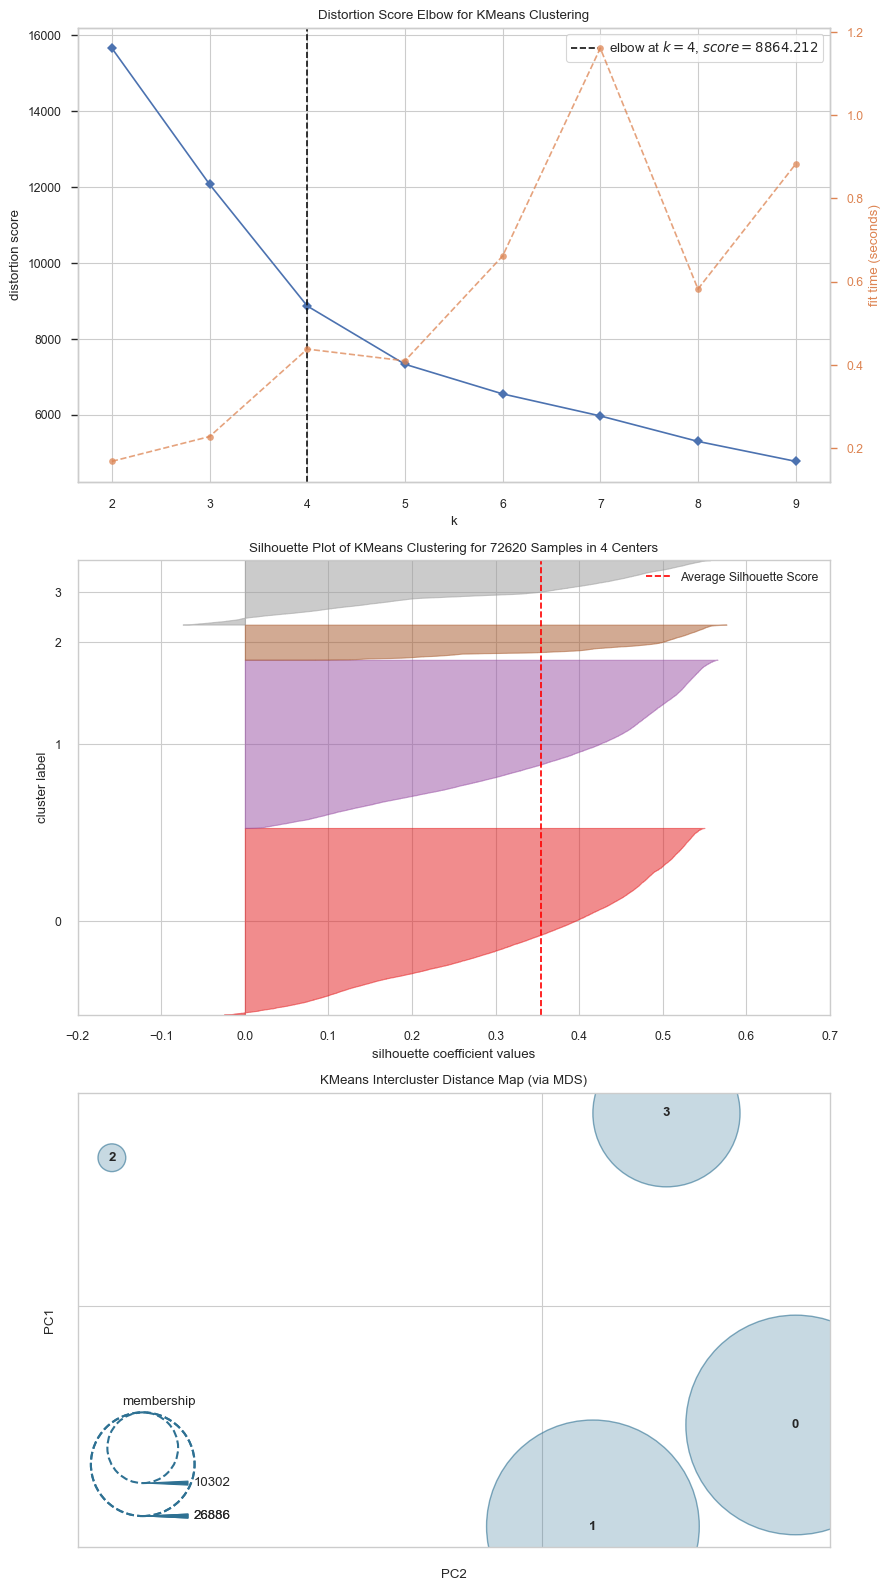

KeyError: "['customer_state'] not in index"

In [53]:
import pandas as pd

# 1) Define your feature combinations
dict_features = {
    'rfm'     : ['recency_days', 'returning_customer', 'total_price_log'],
    'rfms'    : ['recency_days', 'returning_customer', 'total_price_log', 'avg_review_score_imputed'],
    'rfmsd'   : ['recency_days', 'returning_customer', 'total_price_log', 'avg_review_score_imputed', 'delivery_diff_encoded'],
    'rfmsdi'  : ['recency_days', 'returning_customer', 'total_price_log', 'avg_review_score_imputed', 'delivery_diff_encoded', 'order_product_coded'],
    'rfmsdis' : ['recency_days', 'returning_customer', 'total_price_log', 'avg_review_score_imputed', 
                 'delivery_diff_encoded', 'order_product_coded', 'customer_state'],
}

results = {}

for name, cols in dict_features.items():
    # 2) Subset the DF
    X = df[cols].copy()
    
    # 3) One‑hot encode any non‑numeric columns
    #    (detect them by dtype or maintain a known list)
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    # 4) Run your evaluate_clusters
    best_k, fig = evaluate_clusters(
        data=X,
        feature_cols=X.columns.tolist(),
        metric="distortion",  # or "silhouette"
        k_min=2,
        k_max=10
    )
    
    # 5) Store the result
    results[name] = best_k
    
    # (Optionally save each figure under a unique name)
    fig.savefig(f"./results/cluster_diagnostics_{name}.png")
    plt.close(fig)

# After the loop, you have:
print("Optimal k for each feature‑set:")
for name, k in results.items():
    print(f" • {name:8s} → k = {k}")


## Comparing models without functions

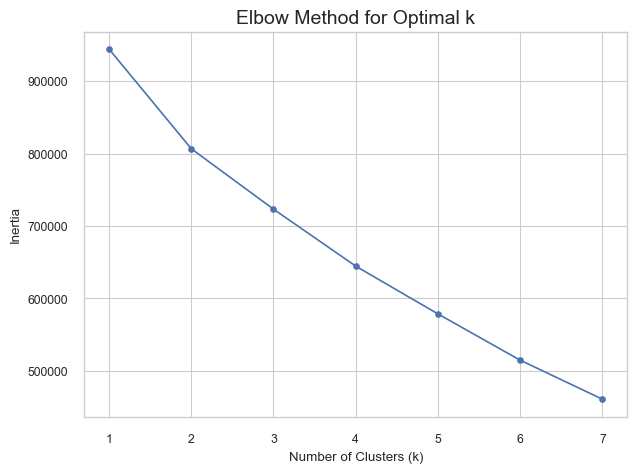

In [8]:
features = df.drop(columns=['customer_unique_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

inertias = []
k_range = range(1, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(7,5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)
plt.grid(True)
plt.savefig(f"./results/figures/elbow_method_for_optimal_K.png")
plt.show()

The inertia (or within-cluster sum of squares) steadily decreases as k increases from 1 to 7 without a clear bend (elbow). This often suggests that the dataset does not have a strongly defined “natural” number of clusters according to inertia alone.

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

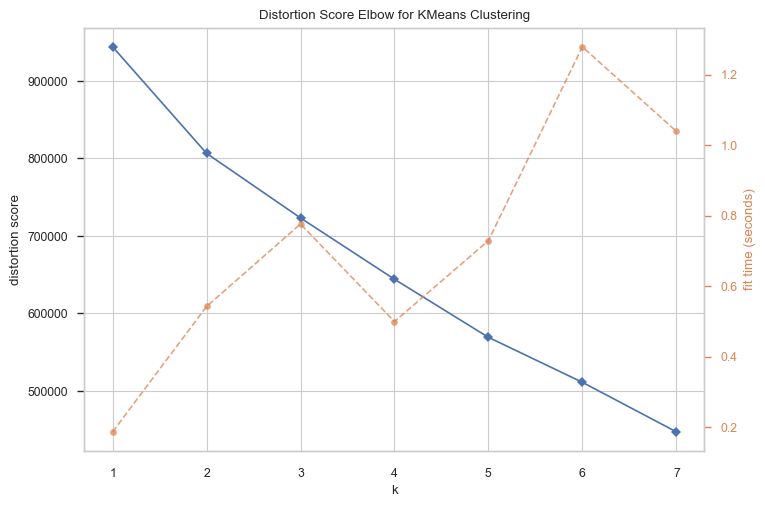

In [10]:
# Yellowbrick visualiser
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.poof(outpath="./results/figures/elbow_method_for_optimal_K.png")

The silhouette score ranges from -1 to 1, with higher values indicating better cluster separation. A lower score suggests that on average, the data points are only marginally better clustered than if they were assigned randomly.

In [46]:
# Silohette analysis
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.3f}")

NameError: name 'X_scaled' is not defined

The Calinski-Harabasz (CH) index measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values generally indicate better-defined clusters.

In [14]:
# Calinski-Harabasz (CH) index
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average calinski-Harabasz score is: {ch_score:.3f}")

For n_clusters = 3, the average calinski-Harabasz score is: 11090.868
For n_clusters = 4, the average calinski-Harabasz score is: 11249.002
For n_clusters = 5, the average calinski-Harabasz score is: 11467.318
For n_clusters = 6, the average calinski-Harabasz score is: 12113.542


The Davies-Bouldin (DB) index evaluates the average similarity between each cluster and its most similar one, where lower values indicate better clustering (i.e., more separation between clusters).

In [22]:
# Davies-Bouldin (DB) index
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    db_score = davies_bouldin_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin score is: {db_score:.3f}")

For n_clusters = 3, the Davies-Bouldin score is: 1.901
For n_clusters = 4, the Davies-Bouldin score is: 1.469
For n_clusters = 5, the Davies-Bouldin score is: 1.333
For n_clusters = 6, the Davies-Bouldin score is: 1.400


### Final cluster selection

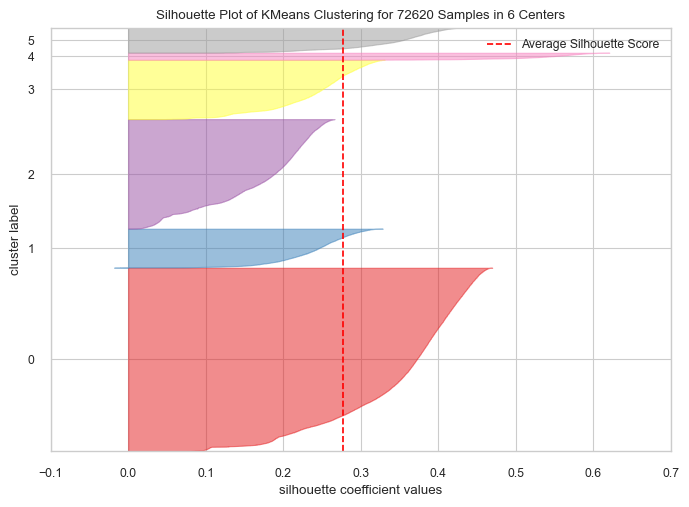

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 72620 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [222]:
# Instantiate the clustering model and visualizer 
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)
visualizer.poof()